In [ ]:
import pandas as pd
import networkx as nx
import pickle
import numpy as np
import matplotlib.pyplot as plt


# Load interactions data
interactions_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/bigger/interactions_bigger.csv")
# Load song data
song_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset/bigger/song_data_bigger.csv")
# Load the co-occurrence graph from the pickle file
with open("/content/drive/MyDrive/Colab Notebooks/dataset/bigger/bigger_graph.pickle", "rb") as f:
    bigger_graph = pickle.load(f)

# Add edges based on co-occurrence relationships
for playlist_id, group in interactions_df.groupby('playlist_id'):
    songs = group['song_id'].tolist()
    for i, song in enumerate(songs):
        for co_song in songs[i+1:]:
            if bigger_graph.has_edge(song, co_song):
                bigger_graph[song][co_song]['weight'] += 1
            else:
                bigger_graph.add_edge(song, co_song, weight=1)

In [ ]:
# import random

# def graph_recommendation(song_name, graph, song_data, num_recommendations=5):
#     recommended_songs = []

#     # Find the song_id corresponding to the given song name
#     song_id = song_data[song_data['song_name'] == song_name]['song_id'].values[0]

#     # Perform a graph walk based on edge weights
#     current_song = song_id
#     for _ in range(num_recommendations):
#         neighbors = list(graph[current_song])
#         if neighbors:
#             # Choose next song based on edge weights
#             next_song = random.choices(neighbors, weights=[graph[current_song][neighbor]['weight'] for neighbor in neighbors])[0]
#             recommended_songs.append(next_song)
#             current_song = next_song
#         else:
#             break

#     # Convert song ids back to song names
#     recommended_songs_names = song_data[song_data['song_id'].isin(recommended_songs)]['song_name'].tolist()
#     return recommended_songs_names
# def recommend_song_names(song_ids, song_data):
#     return song_data[song_data['song_id'].isin(song_ids)]['song_name'].tolist()
# # Example: Recommending songs based on a given song name
# input_song_name = seed_song_highest_closeness_name
# # recommendations = graph_recommendation(input_song_name, bigger_graph, song_data)
# # print("Recommendations based on", input_song_name, ":", recommendations)

In [ ]:
# Compute degree centrality for each node
degree_centrality = nx.degree_centrality(bigger_graph)

# Find the node with the lowest degree centrality
seed_node_lowest_degree = min(degree_centrality, key=degree_centrality.get)
# Find the node with the lowest degree centrality
seed_node_highest_degree = max(degree_centrality, key=degree_centrality.get)

# Retrieve the song names corresponding to the seed nodes
seed_song_lowest_name = song_data[song_data['song_id'] == seed_node_lowest_degree]['song_name'].iloc[0]
seed_song_highest_name = song_data[song_data['song_id'] == seed_node_highest_degree]['song_name'].iloc[0]

In [ ]:
# Function to find song ID by song name
def find_song_id_by_name(song_data, song_name):
    song_id = song_data[song_data['song_name'] == song_name]['song_id'].values
    if len(song_id) > 0:
        return song_id[0]
    else:
        return None

# Function to perform PageRank-based graph walk and recommend songs for a given input song name
def recommend_songs_based_on_pagerank(graph, song_name, k=10):
    # Find song ID by song name
    input_song_id = find_song_id_by_name(song_data, song_name)
    if input_song_id is None:
        print("Input song '{}' not found in the dataset.".format(song_name))
        return []

    # Find neighbors of the input song
    neighbors = graph.neighbors(input_song_id)
    if not neighbors:
        print("Input song '{}' not found in the graph.".format(song_name))
        return []

    # Compute PageRank scores
    pagerank_scores = nx.pagerank(graph)

    # Sort neighbors by PageRank scores
    sorted_neighbors = sorted(neighbors, key=lambda x: pagerank_scores[x], reverse=True)

    # Extract top K recommended songs
    recommended_songs = sorted_neighbors[:k]
    recommended_songs_names = song_data[song_data['song_id'].isin(recommended_songs)]['song_name'].tolist()
    return recommended_songs_names


In [ ]:
# Number of recommendations
k = 10

# Perform recommendations based on PageRank for the input song
input_song_name = seed_song_lowest_name
recommended_songs_pagerank = recommend_songs_based_on_pagerank(bigger_graph, input_song_name, k)
print("Recommended songs based on PageRank for input song '{}':".format(input_song_name))
print("Recommendations based on", input_song_name, ":", recommended_songs_pagerank)
# Perform recommendations based on PageRank for the input song
input_song_name = seed_song_highest_name
recommended_songs_pagerank = recommend_songs_based_on_pagerank(bigger_graph, input_song_name, k)
print("Recommended songs based on PageRank for input song '{}':".format(input_song_name))
print("Recommendations based on", input_song_name, ":", recommended_songs_pagerank)

Recommended songs based on PageRank for input song 'Angels':
Recommendations based on Angels : ['Drop the Game', 'Breezeblocks', 'Mykonos', 'Intro', 'Budapest', 'XO', 'Medicine', 'All I Want', 'Landslide']
Recommended songs based on PageRank for input song 'One Dance':
Recommendations based on One Dance : ['Starboy', 'Congratulations', 'Trap Queen', 'Roses', 'Mr. Brightside', 'Ni**as In Paris', 'Gold Digger', 'Bad and Boujee (feat. Lil Uzi Vert)', 'Broccoli (feat. Lil Yachty)', 'Bohemian Rhapsody - Remastered 2011']


In [ ]:
import random
# Extract edge weights from the graph
edge_weights = nx.get_edge_attributes(bigger_graph, 'weight')

# Normalize edge weights to obtain popularity scores
max_weight = max(edge_weights.values())
popularity_scores = {song: weight / max_weight for (song, weight) in edge_weights.items()}

import random

def recommend_songs(graph, start_song, num_recommendations, steps, popularity_scores):
    current_song = start_song
    recommended_songs = {}

    for _ in range(num_recommendations):
        neighbors = list(graph.neighbors(current_song))
        neighbor_properties = {neighbor: {'name': song_data.loc[song_data['song_id'] == neighbor, 'song_name'].iloc[0],'weight': graph[current_song][neighbor]['weight'], 'common_playlists': graph[current_song][neighbor]['common_playlists']} for neighbor in neighbors}

        # Adjust popularity scores to ensure they are greater than zero
        neighbor_scores = [max(popularity_scores.get(neighbor, 0), 0.01) for neighbor in neighbors]

        # Select the next song based on popularity scores
        next_song = random.choices(neighbors, weights=neighbor_scores)[0]
        recommended_songs[next_song] = neighbor_properties[next_song]
        current_song = next_song

    return recommended_songs

# Example usage
num_recommendations = 10
num_steps = 3
input_song_name = seed_song_highest_name
recommended_songs = recommend_songs(bigger_graph, seed_node_highest_degree, num_recommendations, num_steps, popularity_scores)
print("Recommended songs based on random walk for input song '{}':".format(input_song_name))
for song_id, properties in recommended_songs.items():
    print("Song ID:", properties['name'])
    print("Edge Weight:", properties['weight'])
    print("Common Playlists:", properties['common_playlists'])
    print()


Recommended songs based on random walk for input song 'One Dance':
Song ID: Be Real
Edge Weight: 2
Common Playlists: [1777]

Song ID: Change Locations
Edge Weight: 2
Common Playlists: [1588]

Song ID: I Mean It
Edge Weight: 2
Common Playlists: [1588]

Song ID: It's Tricky
Edge Weight: 2
Common Playlists: [3658]

Song ID: My House
Edge Weight: 4
Common Playlists: [1067, 3658]

Song ID: ABC
Edge Weight: 2
Common Playlists: [1067]

Song ID: (Don't Fear) The Reaper
Edge Weight: 2
Common Playlists: [3271]

Song ID: Another Brick in the Wall, Pt. 2
Edge Weight: 2
Common Playlists: [1101]

Song ID: Welcome To The Jungle
Edge Weight: 2
Common Playlists: [1101]

Song ID: Give Me Love
Edge Weight: 2
Common Playlists: [2522]



<ipython-input-7-2ad583573d41>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Edge Weight')


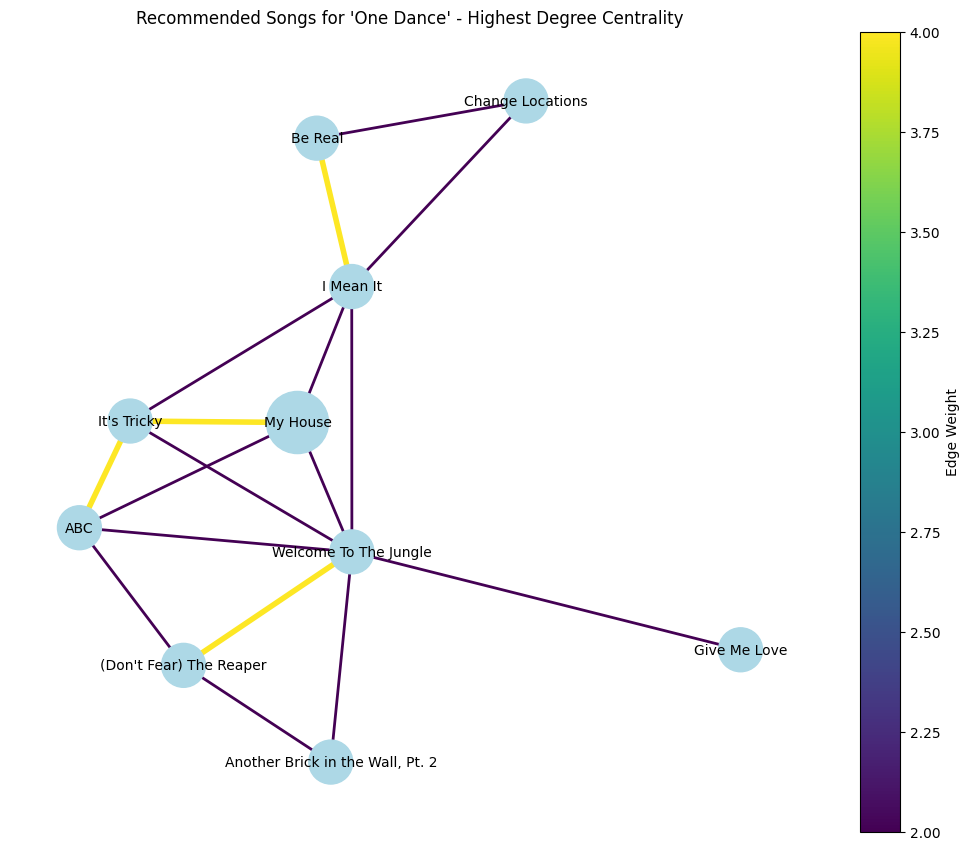

In [ ]:
# Create a new graph for visualization
visualization_graph = nx.Graph()

# Add nodes (recommended songs) to the visualization graph
for song_id, properties in recommended_songs.items():
    visualization_graph.add_node(song_id, name=properties['name'], weight=properties['weight'], common_playlists=properties['common_playlists'])

# Add edges between recommended songs based on their co-occurrence in playlists
for song_id, properties in recommended_songs.items():
    for neighbor_id in bigger_graph.neighbors(song_id):
        if neighbor_id in recommended_songs:  # Only add edges between recommended songs
            weight = bigger_graph[song_id][neighbor_id]['weight']
            visualization_graph.add_edge(song_id, neighbor_id, weight=weight)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(visualization_graph, seed=42)  # Specify the layout algorithm
edge_weights = [visualization_graph[u][v]['weight'] for u, v in visualization_graph.edges()]
node_weights = [properties['weight'] * 500 for properties in recommended_songs.values()]
nx.draw(visualization_graph, pos, labels={node: recommended_songs[node]['name'] for node in visualization_graph.nodes()},
        node_size=node_weights, node_color='lightblue', font_size=10, width=edge_weights, edge_color=edge_weights, edge_cmap=plt.cm.viridis)  # Using Viridis colormap
plt.title("Recommended Songs for 'One Dance' - Highest Degree Centrality")
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))  # Using Viridis colormap
sm.set_array([])
plt.colorbar(sm, label='Edge Weight')
plt.show()

In [ ]:
input_song_name = seed_song_lowest_name
recommended_songs = recommend_songs(bigger_graph, seed_node_highest_degree, num_recommendations, num_steps, popularity_scores)
print("Recommended songs based on random walk for input song '{}':".format(input_song_name))
for song_id, properties in recommended_songs.items():
    print("Song ID:", properties['name'])
    print("Edge Weight:", properties['weight'])
    print("Common Playlists:", properties['common_playlists'])
    print()

Recommended songs based on random walk for input song 'Angels':
Song ID: Hey There Delilah
Edge Weight: 2
Common Playlists: [1343]

Song ID: Paper Planes
Edge Weight: 4
Common Playlists: [1435, 3586]

Song ID: Downtown (feat. Melle Mel, Grandmaster Caz, Kool Moe Dee & Eric Nally)
Edge Weight: 2
Common Playlists: [2006]

Song ID: That's What I Like
Edge Weight: 4
Common Playlists: [2731, 3583]

Song ID: Hall of Fame
Edge Weight: 2
Common Playlists: [2731]

Song ID: Perfect Strangers
Edge Weight: 2
Common Playlists: [2805]

Song ID: Come On Get Higher
Edge Weight: 2
Common Playlists: [2805]

Song ID: Forrest Gump
Edge Weight: 2
Common Playlists: [2805]

Song ID: Waves - Robin Schulz Radio Edit
Edge Weight: 2
Common Playlists: [2805]

Song ID: Wake Me Up - Radio Edit
Edge Weight: 2
Common Playlists: [2792]



<ipython-input-41-15646bed72db>:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Edge Weight')


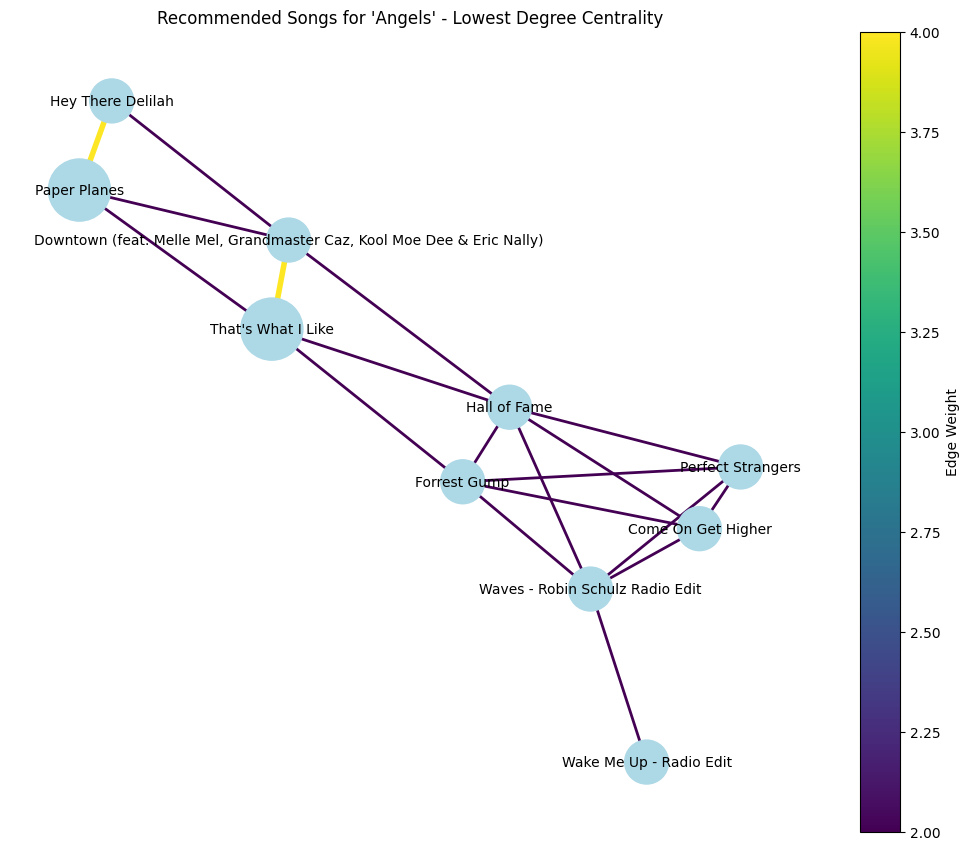

In [ ]:
# Create a new graph for visualization
visualization_graph = nx.Graph()

# Add nodes (recommended songs) to the visualization graph
for song_id, properties in recommended_songs.items():
    visualization_graph.add_node(song_id, name=properties['name'], weight=properties['weight'], common_playlists=properties['common_playlists'])

# Add edges between recommended songs based on their co-occurrence in playlists
for song_id, properties in recommended_songs.items():
    for neighbor_id in bigger_graph.neighbors(song_id):
        if neighbor_id in recommended_songs:  # Only add edges between recommended songs
            weight = bigger_graph[song_id][neighbor_id]['weight']
            visualization_graph.add_edge(song_id, neighbor_id, weight=weight)

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(visualization_graph, seed=42)  # Specify the layout algorithm
edge_weights = [visualization_graph[u][v]['weight'] for u, v in visualization_graph.edges()]
node_weights = [properties['weight'] * 500 for properties in recommended_songs.values()]
nx.draw(visualization_graph, pos, labels={node: recommended_songs[node]['name'] for node in visualization_graph.nodes()},
        node_size=node_weights, node_color='lightblue', font_size=10, width=edge_weights, edge_color=edge_weights, edge_cmap=plt.cm.viridis)  # Using Viridis colormap
plt.title("Recommended Songs for 'Angels' - Lowest Degree Centrality")
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)))  # Using Viridis colormap
sm.set_array([])
plt.colorbar(sm, label='Edge Weight')
plt.show()

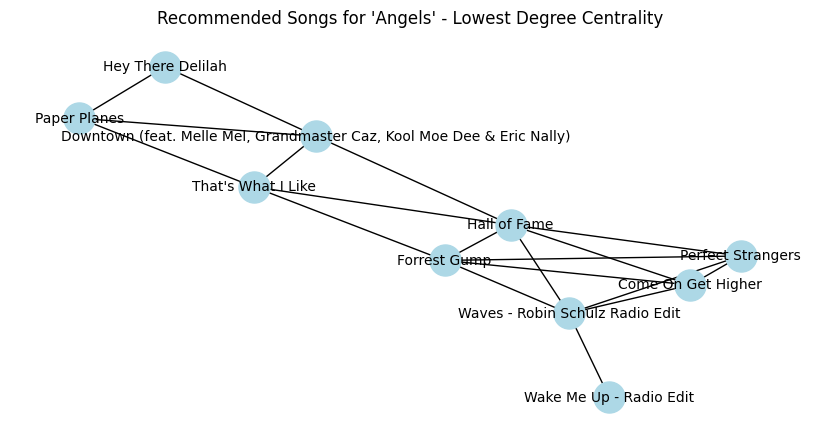

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a new graph for visualization
visualization_graph = nx.Graph()

# Add nodes (recommended songs) to the visualization graph
for song_id, properties in recommended_songs.items():
    visualization_graph.add_node(song_id, name=properties['name'], weight=properties['weight'], common_playlists=properties['common_playlists'])

# Add edges between recommended songs based on their co-occurrence in playlists
for song_id, properties in recommended_songs.items():
    for neighbor_id in bigger_graph.neighbors(song_id):
        if neighbor_id in recommended_songs:  # Only add edges between recommended songs
            visualization_graph.add_edge(song_id, neighbor_id)

# Draw the graph
plt.figure(figsize=(8, 4))
pos = nx.spring_layout(visualization_graph, seed=42)  # Specify the layout algorithm
nx.draw(visualization_graph, pos, labels={node: recommended_songs[node]['name'] for node in visualization_graph.nodes()}, node_size=500, node_color='lightblue', font_size=10)
plt.title("Recommended Songs for 'Angels' - Lowest Degree Centrality")
plt.show()
